# Analysis of dumps
## Raw Data
The test suite stores tcpdump output in a json format. Because this contains information about each packet, it can be parsed to determine information that would not normally be revealed by the transfer program itself. For example, how much overhead or compression there was.

In [60]:
from helpers import get_dumps
import json
import pandas as pd
import numpy as np

PROTOCOLS = ["scp", "ftp", "gridftp"]
N = None # The number of records to retrieve (None=all)

dumps = get_dumps(PROTOCOLS, N)

# Set up DataFrame with correct columns
df = pd.DataFrame(dumps)
df.drop(["host_from", "host_to", "packets"], axis=1, inplace=True)

# Calculate new columns and round
df["time"]  = np.round(df["time"], 2)
df["speed"] = np.round(df["bytes_down"]/df["time"], 2)
df["ratio"] = np.round(df["bytes_total"]/df["file_size"]*100, 2)

# Remove milliseconds from start time
t = pd.to_datetime(df["utc_start_time"])
t = [d.strftime("%Y-%m-%d %H:%M:%S") for d in t]
df["utc_start_time"] = t

# Reorder and rename
df = df[["protocol", "utc_start_time", "file_size", "bytes_down",
         "bytes_up", "bytes_total", "ratio", "time", "speed"]] 
df.columns = ["Protocol", "Start Time", "File Size (bytes)", "Bytes Down", "Bytes Up",
              "Bytes Total", "Ratio (%)", "Time (s)", "Speed (bytes/s)"]

df

,Protocol,Start Time,File Size (bytes),Bytes Down,Bytes Up,Bytes Total,Ratio (%),Time (s),Speed (bytes/s)
0,ftp,2015-09-25 17:52:34,6,3317,4129,7446,124100.00,6.69,495.81
1,ftp,2015-09-26 12:22:51,6,3317,4069,7386,123100.00,9.58,346.24
2,gridftp,2015-09-25 17:52:43,6,3911,4145,8056,134266.67,5.85,668.55
3,gridftp,2015-09-26 12:23:03,6,4027,4233,8260,137666.67,5.62,716.55
4,scp,2015-09-25 17:52:51,6,2745,3633,6378,106300.00,3.68,745.92
5,scp,2015-09-26 12:23:10,6,2717,3633,6350,105833.33,3.94,689.59


## Topography of Transfer
Displaying the packet sizes against a time axis gives more insight into each protocol. It's also a good representation of network conditions, as breaks or delays are easily seen.

<IPython.core.display.Javascript object>


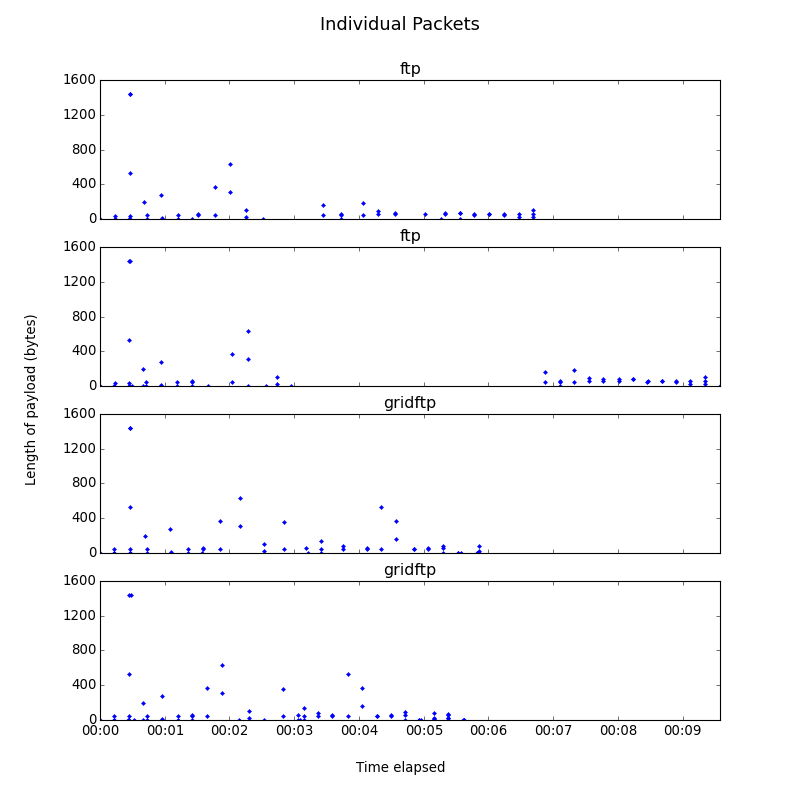

In [26]:
%matplotlib notebook
from matplotlib import dates, pyplot as plt, rcParams
from datetime import datetime, timedelta
from helpers import TIME_FORMAT

PLOT_TIME_FORMAT = "%M:%S"
rcParams['figure.figsize'] = (10, 10)

# Convert all the times to an offset from 0
xy = []
for dump in dumps:
    x = [datetime.strptime(l["time"], TIME_FORMAT) for l in dump["packets"]]
    t0 = min(x)
    dt = timedelta(hours=t0.hour, minutes=t0.minute, seconds=t0.second,
                   microseconds=t0.microsecond)
    x = [t-dt for t in x]
    y = [l["length"] for l in dump["packets"]]
    xy.append((x, y))

fig, axes = plt.subplots(4, sharex="col")
max_yticks = 4

for i in range(4):
    axes[i].plot(xy[i][0], xy[i][1], ".")
    axes[i].xaxis.set_major_formatter(dates.DateFormatter(PLOT_TIME_FORMAT))
    axes[i].set_title(dumps[i]["protocol"])
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(max_yticks))

fig.text(0.5, 0.04, "Time elapsed", ha='center', va='center')
fig.text(0.04, 0.5, "Length of payload (bytes)", ha='center', va='center', rotation='vertical')
fig.suptitle("Individual Packets", size=16)
fig.show()
